# Obteniendo gráfica de las frecuencias a partir de la data procesada

In [8]:
import numpy as np
import os

# Para el lin

In [9]:
tries_lin = []

for i in range(10):
    energylist = []
    directorypath = f'../outputs/energy2/tries_lin/{i+1}'
    for j in range(9):
        energylist.append(np.load(directorypath + '/microphone' + str(j+1) + '.npy'))
    tries_lin.append(energylist)

In [10]:
directory = '../data/aligned/lin'
files = os.listdir(directory)  # Lista todos los archivos en el directorio

# Inicializar un diccionario para almacenar las energías temporales
data = []

# Recorre cada archivo .npy y calcula la energía temporal para cada trama
for file in files:
    if file.endswith('.npy'):
        # Cargar el mel-espectrograma
        filepath = os.path.join(directory, file)
        mel_spectrogram = np.load(filepath)
        data.append(mel_spectrogram)

In [11]:
tries_lin_frequency = []
for j in range(10):
    frequencylist = []

    for i in range(9):
        array = np.zeros(tries_lin[j][i].shape[0])
        frequencylist.append(array)

        for k in range(tries_lin[j][i].shape[0]):
            if tries_lin[j][i][k] - 0 > 0.0001:
                frequencylist[i][k] = np.argmax(data[i][:, k]) + 60
    
    tries_lin_frequency.append(frequencylist)

In [12]:
for i in range(10):
    tries_lin_frequency_output_path = f'../outputs/frequency/tries_lin/{i+1}/'
    if not os.path.exists(tries_lin_frequency_output_path):
        os.makedirs(tries_lin_frequency_output_path)
    for j in range (9):
        np.save(tries_lin_frequency_output_path + 'microphone' + str(j+1) + '.npy', tries_lin_frequency[i][j])

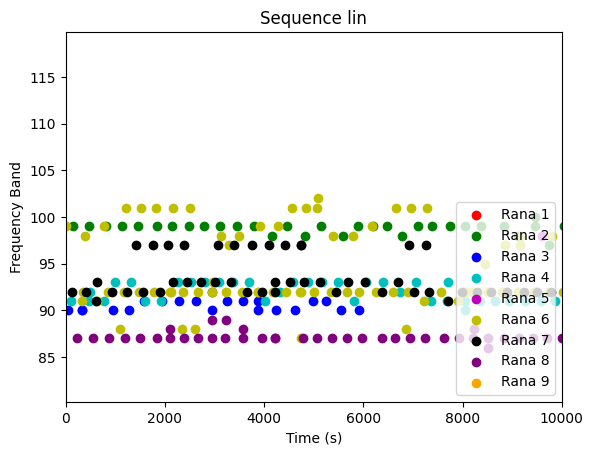

In [20]:
import numpy as np
import matplotlib.pyplot as plt

hop_length = 512
sample_rate = 96000
intervalo_tiempo = hop_length / sample_rate

# Define colores para cada array
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange']
# colors = plt.cm.get_cmap('tab10', 9).colors
# colors = plt.cm.get_cmap('Set1', 9).colors
# colors = plt.cm.get_cmap('Paired', 9).colors
# colors = plt.cm.get_cmap('Accent', 9).colors
# colors = plt.cm.get_cmap('tab20b', 9).colors
# colors = ["#FF5733", "#33FF57", "#3357FF", "#FF33A6", "#FF8C33", "#33FFF6", "#8D33FF", "#FF3333", "#33FF8C"]





for i, array in enumerate(tries_lin_frequency[0]):
    indices_no_cero = np.where(array > 0.0001)[0]
    valores_no_cero = array[indices_no_cero]

    # Convierte los índices a milisegundos
    milisegundos = indices_no_cero * intervalo_tiempo

    plt.scatter(indices_no_cero, valores_no_cero, color=colors[i], label=f'Rana {i+1}')

# Configura el gráfico
# plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Band')
plt.legend(loc='lower right')
plt.title('Sequence lin')
plt.xlim(0,10000)

# Muestra el gráfico
plt.show()

# Para el co

In [14]:
tries_co = []

for i in range(10):
    energylist = []
    directorypath = f'../outputs/energy2/tries_co/{i+1}'
    for j in range(9):
        energylist.append(np.load(directorypath + '/microphone' + str(j+1) + '.npy'))
    tries_co.append(energylist)

In [15]:
directory = '../data/aligned/co'
files = os.listdir(directory)  # Lista todos los archivos en el directorio

# Inicializar un diccionario para almacenar las energías temporales
data = []

# Recorre cada archivo .npy y calcula la energía temporal para cada trama
for file in files:
    if file.endswith('.npy'):
        # Cargar el mel-espectrograma
        filepath = os.path.join(directory, file)
        mel_spectrogram = np.load(filepath)
        data.append(mel_spectrogram)

In [16]:
tries_co_frequency = []
for j in range(10):
    frequencylist = []

    for i in range(9):
        array = np.zeros(tries_co[j][i].shape[0])
        frequencylist.append(array)

        for k in range(tries_co[j][i].shape[0]):
            if tries_co[j][i][k] - 0 > 0.0000001:
                frequencylist[i][k] = np.argmax(data[i][:, k])
    
    tries_co_frequency.append(frequencylist)

In [17]:
for i in range(10):
    tries_co_frequency_output_path = f'../outputs/frequency/tries_co/{i+1}/'
    if not os.path.exists(tries_co_frequency_output_path):
        os.makedirs(tries_co_frequency_output_path)
    for j in range (9):
        np.save(tries_co_frequency_output_path + 'microphone' + str(j+1) + '.npy', tries_co_frequency[i][j])

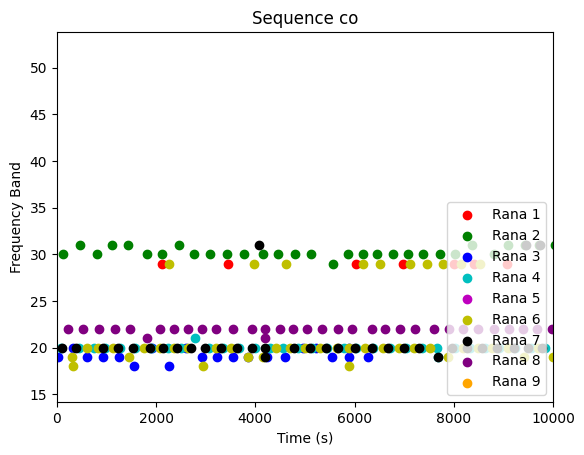

In [21]:
import numpy as np
import matplotlib.pyplot as plt

hop_length = 512
sample_rate = 96000
intervalo_tiempo = hop_length / sample_rate

# Define colores para cada array
colore = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange']
# colors = plt.cm.get_cmap('tab10', 9).colors


for i, array in enumerate(tries_co_frequency[0]):
    indices_no_cero = np.where(array > 0.0001)[0]
    valores_no_cero = array[indices_no_cero]

    # Convierte los índices a milisegundos
    milisegundos = indices_no_cero * intervalo_tiempo

    plt.scatter(indices_no_cero, valores_no_cero, color=colors[i], label=f'Rana {i+1}')

# Configura el gráfico
# plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency Band')
plt.legend(loc='lower right')
plt.title('Sequence co')
plt.xlim(0,10000)

# Muestra el gráfico
plt.show()

# 20231021_190000A10.WAV

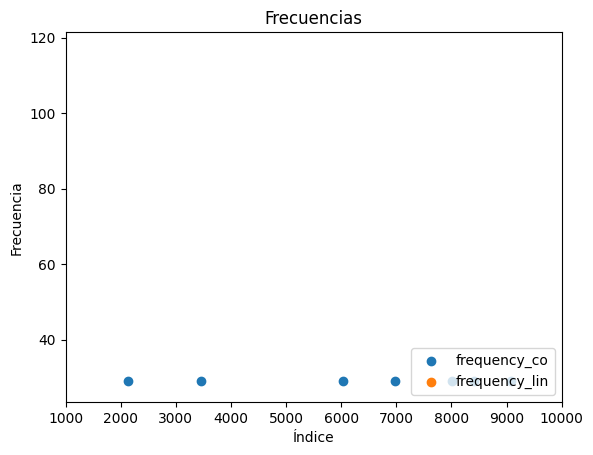

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Carga los datos de los archivos .npy
datos_co = np.load('../outputs/energy2/tries_co/1/microphone1.npy')
datos_lin = np.load('../outputs/energy2/tries_lin/1/microphone1.npy')


frequency_co = np.zeros(datos_co.shape[0])

for j in range(datos_co.shape[0]):
    if datos_co[j] - 0 > 0.0001:
        frequency_co[j] = np.argmax(data[0][:, j])



frequency_lin = np.zeros(datos_lin.shape[0])

for j in range(datos_lin.shape[0]):
    if datos_lin[j] - 0 > 0.0001:
        frequency_lin[j] = np.argmax(data[0][:, j]) + 60



import matplotlib.pyplot as plt

# Genera los valores x
x_co = np.arange(len(frequency_co))
x_lin = np.arange(len(frequency_lin))

# Crea una máscara booleana para los valores que no son cero
mask_co = frequency_co != 0
mask_lin = frequency_lin != 0

# Crea una nueva figura
plt.figure()

# Trama los datos de 'frequency_co' que no son cero
plt.scatter(x_co[mask_co], frequency_co[mask_co], label='frequency_co')

# Trama los datos de 'frequency_lin' que no son cero
plt.scatter(x_lin[mask_lin], frequency_lin[mask_lin], label='frequency_lin')

# Configura el gráfico
plt.xlabel('Índice')
plt.ylabel('Frecuencia')
plt.legend(loc='lower right')
plt.title('Frecuencias')
plt.xlim(1000, 10000)

# Muestra el gráfico
plt.show()